In [102]:
pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 4.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [43]:
try:
    import import_ipynb
except :
    !pip install import_ipynb
    import import_ipynb
import Predistim_Library as pl
import nibabel as nib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import laBIBILaRORO as lbr

In [44]:
region_mapping = {
    "GP_e_L": 3,
    "GP_i_L": 4,
    "GP_i_R": 104,
    "GP_e_R": 103
}

In [11]:
import os
np.set_printoptions(precision=3)
df1 = pd.read_excel(os.path.join(pl.STUDY_PATH,"csv_xlsx",'Analyse_Imagerie_Predistim_V4_20210208.xlsx'),engine='openpyxl',index_col=0)
df1.rename(columns={'MoCA_TOT _V0':'MoCA_TOT_V0'},inplace=True)
df1=df1.loc[:,~df1.columns.str.startswith('R2_')]

Crée un masque des voxels dont l'intensité R2* depasse la mediane+2 IQR de la structure
Récupère :
    volume de la strcuture 
    volume du masque
    le R2* median de la structure
    l'IQR du R2* de la structure
    le QSM mpyen du masque


In [22]:
def calculate_region_mean_QSM_above_threshold(subject_name):
    # Définir les chemins des fichiers pour le sujet donné
    image_paths = [
        f"/NAS/deathrow/protocoles/predistim/QSM/{subject_name}/QSM_lin_3DT1.nii.gz",
        f"/NAS/deathrow/protocoles/predistim/R2/{subject_name}/R2_lin_3DT1.nii.gz",
        f"/NAS/deathrow/protocoles/predistim/3DT1/{subject_name}/combined_{subject_name}_on3DT1.nii.gz"
    ]
    
    # Charger les images
    image_QSM = nib.load(image_paths[0]).get_fdata()
    image_R2s = nib.load(image_paths[1]).get_fdata()
    image_struct = nib.load(image_paths[2]).get_fdata()
    
    # Calculer les valeurs de region_mean_QSM_above_threshold
    region_mean_QSM_above_threshold = {}
    for region, value in region_mapping.items():
        # Créer un masque pour la région
        region_mask = (image_struct == value)
        
        # Créer un masque pour les voxels de R2s qui dépassent la médiane + 2 IQR
        region_values_R2s = image_R2s[region_mask]
        median_R2s = np.median(region_values_R2s)
        iqr_R2s = np.percentile(region_values_R2s, 75) - np.percentile(region_values_R2s, 25)
        threshold_R2s = median_R2s + 2 * iqr_R2s
        mask_above_threshold_R2s = (image_R2s > threshold_R2s) & region_mask
        
        # Calculer les volumes en termes de nombre de pixels pour les masques
        region_mean_QSM_above_threshold[f"{region}_volume_total"] = region_mask.sum()
        region_mean_QSM_above_threshold[f"{region}_volume_above_threshold"] = mask_above_threshold_R2s.sum()
        
        # Calculer la médiane et l'IQR des valeurs de R2s pour cette région
        region_mean_QSM_above_threshold[f"{region}_r2s_median"] = median_R2s
        region_mean_QSM_above_threshold[f"{region}_r2s_iqr"] = iqr_R2s

        
        # Calculer la moyenne des valeurs de QSM pour ce masque
        region_values_QSM = image_QSM[mask_above_threshold_R2s]
        region_mean_QSM_above_threshold[f"{region}_qsm_moyen"] = region_values_QSM.mean()
    
    return region_mean_QSM_above_threshold

In [23]:
import os
import glob

qsm_files = glob.glob("/NAS/deathrow/protocoles/predistim/QSM/*/QSM_lin_3DT1.nii.gz")
results = []
for qsm_file in qsm_files:
    subj = os.path.basename(os.path.dirname(qsm_file))
    struct_file = f"/NAS/deathrow/protocoles/predistim/3DT1/{subj}/combined_{subj}_on3DT1.nii.gz"
    if os.path.isfile(struct_file):
        vals=calculate_region_mean_QSM_above_threshold(subj)
        print(f"Valeurs pour le sujet {subj}: {vals}")
        results.append({'Subject': subj, **vals})

df_results = pd.DataFrame(results)

Valeurs pour le sujet 01023CF: {'GP_e_L_volume_total': 904, 'GP_e_L_volume_above_threshold': 94, 'GP_e_L_r2s_median': 42.49412626290869, 'GP_e_L_r2s_iqr': 11.59834919317015, 'GP_e_L_qsm_moyen': -0.057395131177890156, 'GP_i_L_volume_total': 384, 'GP_i_L_volume_above_threshold': 9, 'GP_i_L_r2s_median': 39.0909884440078, 'GP_i_L_r2s_iqr': 6.247041912973124, 'GP_i_L_qsm_moyen': -0.03528075667036487, 'GP_i_R_volume_total': 403, 'GP_i_R_volume_above_threshold': 1, 'GP_i_R_r2s_median': 36.632852771516596, 'GP_i_R_r2s_iqr': 13.258900229856643, 'GP_i_R_qsm_moyen': -0.061202539467598696, 'GP_e_R_volume_total': 969, 'GP_e_R_volume_above_threshold': 67, 'GP_e_R_r2s_median': 42.25585015708435, 'GP_e_R_r2s_iqr': 18.075214648125026, 'GP_e_R_qsm_moyen': -0.06550574405376584}
Valeurs pour le sujet 06004CS: {'GP_e_L_volume_total': 835, 'GP_e_L_volume_above_threshold': 8, 'GP_e_L_r2s_median': 43.238610449392766, 'GP_e_L_r2s_iqr': 19.828959123716217, 'GP_e_L_qsm_moyen': -0.08130734458403023, 'GP_i_L_volum

/tmp/ipykernel_1147218/3614719117.py:38: RuntimeWarning: Mean of empty slice.
  region_mean_QSM_above_threshold[f"{region}_qsm_moyen"] = region_values_QSM.mean()
/home/global/Anaconda3-2023.09/envs/conda_env_3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Valeurs pour le sujet 06011SB: {'GP_e_L_volume_total': 816, 'GP_e_L_volume_above_threshold': 31, 'GP_e_L_r2s_median': 36.6358484466677, 'GP_e_L_r2s_iqr': 7.585199667236118, 'GP_e_L_qsm_moyen': -0.05023684308668558, 'GP_i_L_volume_total': 361, 'GP_i_L_volume_above_threshold': 1, 'GP_i_L_r2s_median': 33.19121623250918, 'GP_i_L_r2s_iqr': 7.4925445428956685, 'GP_i_L_qsm_moyen': -0.014114769978717832, 'GP_i_R_volume_total': 350, 'GP_i_R_volume_above_threshold': 0, 'GP_i_R_r2s_median': 33.892485732834466, 'GP_i_R_r2s_iqr': 5.812202947751288, 'GP_i_R_qsm_moyen': nan, 'GP_e_R_volume_total': 807, 'GP_e_R_volume_above_threshold': 38, 'GP_e_R_r2s_median': 37.691909607168085, 'GP_e_R_r2s_iqr': 6.460473166554877, 'GP_e_R_qsm_moyen': -0.028089527246666444}
Valeurs pour le sujet 06032BM: {'GP_e_L_volume_total': 1439, 'GP_e_L_volume_above_threshold': 161, 'GP_e_L_r2s_median': 32.01955537969197, 'GP_e_L_r2s_iqr': 6.773415624724059, 'GP_e_L_qsm_moyen': -0.08525746552982949, 'GP_i_L_volume_total': 655, '

In [ ]:
df_results = pd.DataFrame(results)
df_results.index=df_results['Subject']

In [44]:
df_results.to_csv('/NAS/deathrow/protocoles/predistim/QSM/region_mean_QSM_above_threshold.csv', index=False)

In [35]:
df_results = pd.read_csv('/NAS/deathrow/protocoles/predistim/QSM/region_mean_QSM_above_threshold.csv')
df_results.index=df_results['Subject']
df_results.describe()

,GP_e_L_volume_total,GP_e_L_volume_above_threshold,GP_e_L_r2s_median,GP_e_L_r2s_iqr,GP_e_L_qsm_moyen,GP_i_L_volume_total,GP_i_L_volume_above_threshold,GP_i_L_r2s_median,GP_i_L_r2s_iqr,GP_i_L_qsm_moyen,GP_i_R_volume_total,GP_i_R_volume_above_threshold,GP_i_R_r2s_median,GP_i_R_r2s_iqr,GP_i_R_qsm_moyen,GP_e_R_volume_total,GP_e_R_volume_above_threshold,GP_e_R_r2s_median,GP_e_R_r2s_iqr,GP_e_R_qsm_moyen
count,297.000000,297.000000,297.000000,297.000000,281.000000,297.000000,297.000000,297.000000,297.000000,214.000000,297.000000,297.000000,297.000000,297.000000,221.000000,297.000000,297.000000,297.000000,297.000000,277.000000
mean,893.114478,40.676768,37.942262,11.262146,-0.064724,404.269360,9.622896,34.522899,7.992777,-0.088097,403.400673,9.582492,34.241154,8.107114,-0.101968,945.579125,42.030303,37.594345,11.298039,-0.054983
std,121.558991,38.997703,4.557132,8.728585,0.056618,55.249509,14.023600,3.656899,3.957290,0.080145,55.246234,14.051814,3.747863,4.191918,0.070949,131.504244,40.500281,4.495794,7.798278,0.058530
min,595.000000,0.000000,25.737828,1.810923,-0.262532,273.000000,0.000000,24.537405,1.449442,-0.476360,272.000000,0.000000,24.768786,1.685776,-0.403824,671.000000,0.000000,25.167652,1.829987,-0.405530
25%,815.000000,8.000000,35.080111,6.772190,-0.099433,368.000000,0.000000,32.231444,5.637811,-0.134062,365.000000,0.000000,31.904311,5.546053,-0.142395,855.000000,9.000000,34.808137,6.988683,-0.091109
50%,890.000000,27.000000,37.441674,8.863096,-0.061795,402.000000,4.000000,34.401450,7.394698,-0.086270,402.000000,4.000000,34.020647,7.181123,-0.092915,930.000000,29.000000,37.285555,9.194055,-0.054269
75%,962.000000,67.000000,40.558381,12.117876,-0.026815,433.000000,12.000000,36.484432,8.930330,-0.050051,435.000000,12.000000,36.195869,9.719147,-0.057467,1016.000000,71.000000,39.996173,12.128429,-0.019947
max,1439.000000,161.000000,58.624540,76.697107,0.150489,655.000000,72.000000,51.884088,36.572995,0.353074,634.000000,81.000000,47.995346,42.613068,0.112624,1545.000000,180.000000,61.341818,63.222165,0.093963


In [36]:
df_results.fillna(0, inplace=True)

In [37]:
# Calculer l'asymétrie entre les colonnes gauche (_L_) et droite (_R_)
for region in ['GP_e', 'GP_i']:
    for metric in ['volume_total', 'volume_above_threshold', 'r2s_median', 'r2s_iqr', 'qsm_moyen']:
        left_col = f"{region}_L_{metric}"
        right_col = f"{region}_R_{metric}"
        if left_col in df_results.columns and right_col in df_results.columns:
            # Différence absolue
            df_results[f"asymmetry_abs_{region}_{metric}"] = abs(df_results[left_col] - df_results[right_col])
            # Différence relative
            df_results[f"asymmetry_rel_{region}_{metric}"] = df_results[f"asymmetry_abs_{region}_{metric}"] / (df_results[left_col] + df_results[right_col])

In [47]:
df_common=df1.join(df_results, how='left')
df_common.describe()

,Age,DIS_DUR_DIAG_V0,BMI,Sexe,Centre,UPDRS_III_WOFF_V0,DOPA_SEN_V0,UPDRS_TOT_OFF_V0,HY_OFF_V0,UPDRS_I _V0,...,asymmetry_abs_GP_i_volume_total,asymmetry_rel_GP_i_volume_total,asymmetry_abs_GP_i_volume_above_threshold,asymmetry_rel_GP_i_volume_above_threshold,asymmetry_abs_GP_i_r2s_median,asymmetry_rel_GP_i_r2s_median,asymmetry_abs_GP_i_r2s_iqr,asymmetry_rel_GP_i_r2s_iqr,asymmetry_abs_GP_i_qsm_moyen,asymmetry_rel_GP_i_qsm_moyen
count,428.000000,426.000000,389.000000,428.000000,428.000000,410.000000,409.000000,409.000000,405.000000,406.000000,...,293.000000,293.000000,293.000000,253.000000,293.000000,293.000000,293.000000,293.000000,293.000000,253.000000
mean,60.102804,9.544601,24.784285,1.348131,9.165888,41.714634,74.443032,78.234719,2.606173,11.825123,...,18.610922,0.022976,5.713311,0.550004,1.766401,0.025565,1.874343,0.115734,0.056186,-0.461319
std,7.421640,3.893782,4.002659,0.476935,5.861641,16.740476,14.293210,26.675127,0.870209,5.455676,...,18.940755,0.022681,6.432451,0.370447,1.611887,0.022604,1.944304,0.090596,0.055655,0.991735
min,30.000000,2.000000,15.622619,1.000000,1.000000,7.000000,12.500000,19.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.011186,0.000153,0.000898,0.000102,0.000000,-8.116337
25%,55.000000,7.000000,22.093170,1.000000,6.000000,29.000000,65.200000,60.000000,2.000000,8.000000,...,7.000000,0.008827,1.000000,0.200000,0.613942,0.008830,0.694778,0.046471,0.015345,-1.000000
50%,62.000000,9.000000,24.567474,1.000000,7.000000,39.000000,76.900000,74.000000,2.500000,11.000000,...,14.000000,0.017094,4.000000,0.529412,1.380189,0.020356,1.422243,0.094311,0.042013,-0.301107
75%,66.000000,11.750000,27.281746,2.000000,17.000000,51.000000,84.800000,94.000000,3.000000,15.000000,...,22.000000,0.029024,8.000000,1.000000,2.467811,0.035461,2.311139,0.163045,0.078598,-0.112359
max,73.000000,32.000000,41.914342,2.000000,19.000000,126.000000,100.000000,166.000000,5.000000,32.000000,...,132.000000,0.170984,30.000000,1.000000,12.274910,0.167664,18.414527,0.500229,0.415488,4.990790


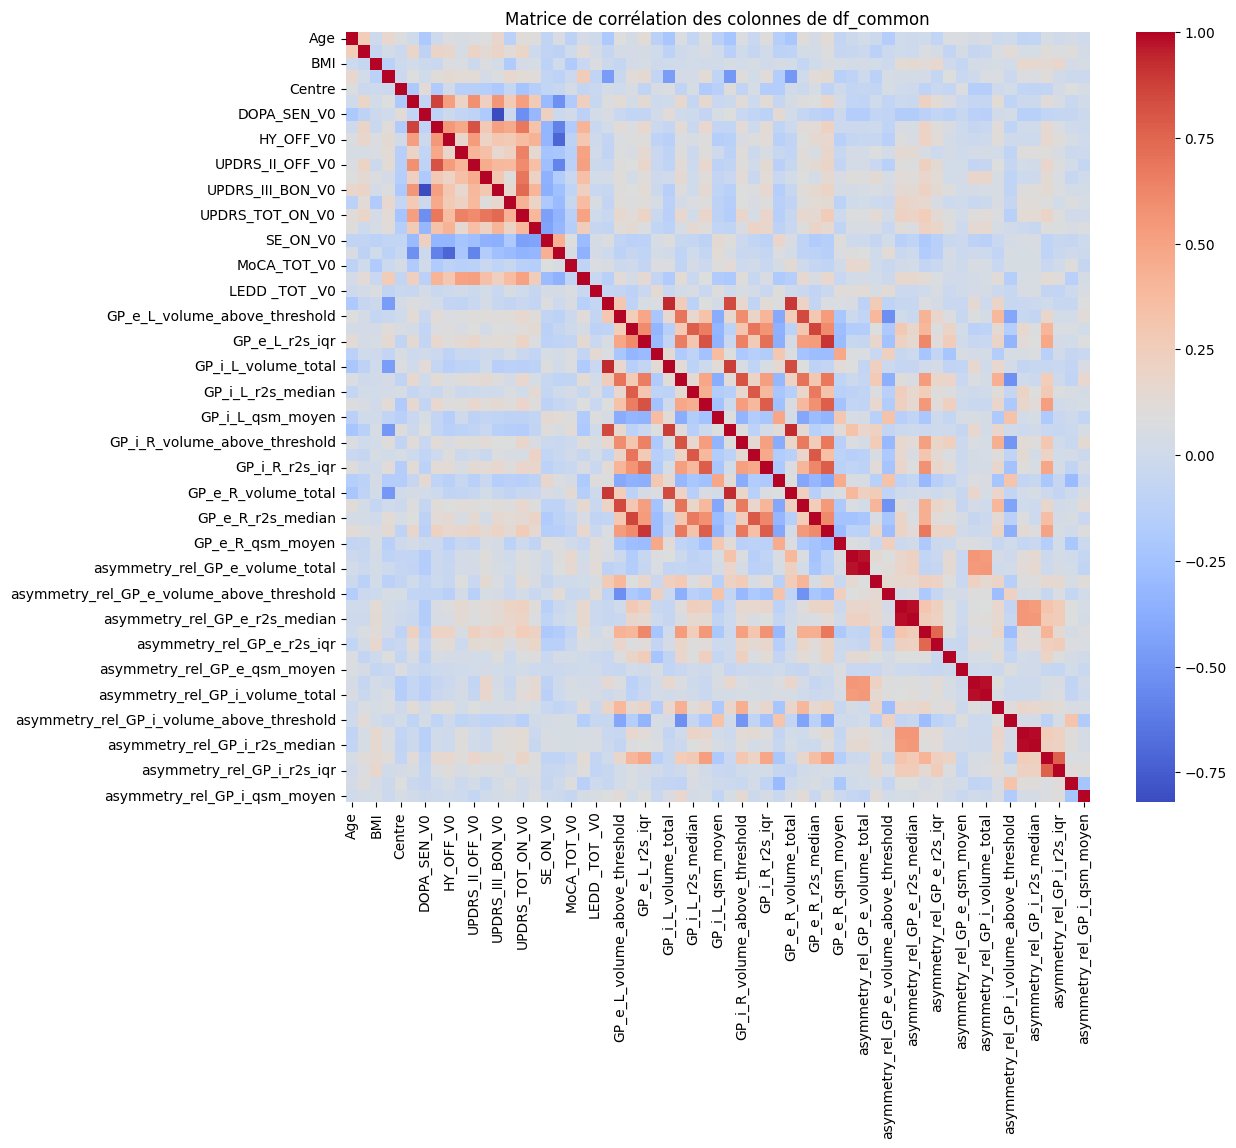

In [ ]:
# Sélectionner uniquement les colonnes numériques
numeric_columns = df_common.select_dtypes(include=[np.number])

# Calculer la matrice de corrélation
correlation_matrix = numeric_columns.corr()

# Visualiser la matrice de corrélation avec une heatmap sans annotations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélation des colonnes de df_common")
plt.show()

In [89]:
df1.filter(regex="^(DOPA|UPDRS)", axis=1).columns

Index(['UPDRS_III_WOFF_V0', 'DOPA_SEN_V0', 'UPDRS_TOT_OFF_V0', 'UPDRS_I _V0',
       'UPDRS_II_OFF_V0', 'UPDRS_II_ON_V0', 'UPDRS_III_BON_V0', 'UPDRS_IV _V0',
       'UPDRS_TOT_ON_V0'],
      dtype='object')

Index(['UPDRS_III_WOFF_V0', 'DOPA_SEN_V0', 'UPDRS_TOT_OFF_V0', 'UPDRS_I _V0',
       'UPDRS_II_OFF_V0', 'UPDRS_II_ON_V0', 'UPDRS_III_BON_V0', 'UPDRS_IV _V0',
       'UPDRS_TOT_ON_V0'],
      dtype='object')


IndexError: index 0 is out of bounds for axis 0 with size 0

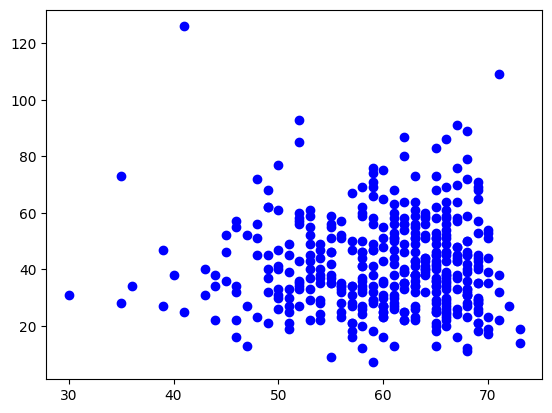

In [93]:
listeTargetVar=df1.filter(regex="^(DOPA|UPDRS)", axis=1).columns
print(listeTargetVar)
lbr.regress_covar_func(listeTargetVar,["Age"],df_common,df_common,display=True)

In [42]:
from scipy.stats import pearsonr
import plotly.express as px
import numpy as np

def pearsonr_ci(x, y, alpha=0.05):
    """Calculate the Pearson correlation coefficient and its confidence interval."""
    r, p = pearsonr(x, y)
    n = len(x)
    # Standard error for Fisher's z-transformation
    se = 1 / np.sqrt(n - 3)
    
    # Fisher's z-transformation of the Pearson correlation coefficient
    z = np.arctanh(r)
    
    # Calculate the confidence interval in the z-space
    z_ci = [z - se * 1.96, z + se * 1.96]  # 95% confidence interval
    
    # Transform the confidence interval back to the r-space using the hyperbolic tangent
    r_ci = np.tanh(z_ci)
    
    return r, p, r_ci

# Check if the required columns exist in df_common
for col in df1.filter(regex="^(DOPA|UPDRS)", axis=1):
    print(f"Processing column: {col}")
    # Create a scatter plot with a trendline
    for asymmetry_col in ["asymmetry_abs_GP_e_qsm_moyen", "asymmetry_abs_GP_e_r2s_median"]:
        print(f"Processing asymmetry column: {asymmetry_col}")
        # Calculate Pearson correlation and confidence interval
        x_data = df_common[asymmetry_col]
        y_data = df_common[col]
        mask = ~x_data.isna() & ~y_data.isna()  # Filter NaN values
        r, p, r_ci = pearsonr_ci(x_data[mask], y_data[mask])
        print(f"Pearson correlation: r={r:.2f}, p-value={p:.2e}, CI=[{r_ci[0]:.2f}, {r_ci[1]:.2f}]")
        # Only display the plot if the correlation is greater than 0.2
        if abs(r) > 0.2:
            for color_col in ["Age", "BMI"]:  # Include both Age and BMI
                fig = px.scatter(
                    df_common,
                    x=asymmetry_col,
                    y=col,
                    color=color_col,
                    trendline="ols",  # Add a trendline
                    title=(
                        f"Scatter plot with trendline ({col} vs {asymmetry_col})<br>"
                        f"r={r:.2f}, p={p:.2e}, CI=[{r_ci[0]:.2f}, {r_ci[1]:.2f}]"
                    ),
                    labels={
                        asymmetry_col: f"Absolute asymmetry of GP_e ({asymmetry_col.split('_')[-1]})",
                        color_col: color_col,
                        col: col
                    }
                )
                # Save the figure as an image
                fig.write_image(f"/NAS/deathrow/protocoles/predistim/screenshots/{col}_vs_{asymmetry_col}_colored_by_{color_col}.png")
                fig.show()


Processing column: UPDRS_III_WOFF_V0
Processing asymmetry column: asymmetry_abs_GP_e_qsm_moyen
Pearson correlation: r=0.06, p-value=3.29e-01, CI=[-0.06, 0.17]
Processing asymmetry column: asymmetry_abs_GP_e_r2s_median
Pearson correlation: r=-0.03, p-value=6.01e-01, CI=[-0.15, 0.08]
Processing column: DOPA_SEN_V0
Processing asymmetry column: asymmetry_abs_GP_e_qsm_moyen
Pearson correlation: r=-0.11, p-value=5.73e-02, CI=[-0.22, 0.00]
Processing asymmetry column: asymmetry_abs_GP_e_r2s_median
Pearson correlation: r=-0.16, p-value=5.09e-03, CI=[-0.27, -0.05]
Processing column: UPDRS_TOT_OFF_V0
Processing asymmetry column: asymmetry_abs_GP_e_qsm_moyen
Pearson correlation: r=0.06, p-value=3.49e-01, CI=[-0.06, 0.17]
Processing asymmetry column: asymmetry_abs_GP_e_r2s_median
Pearson correlation: r=0.06, p-value=3.49e-01, CI=[-0.06, 0.17]
Processing column: UPDRS_I _V0
Processing asymmetry column: asymmetry_abs_GP_e_qsm_moyen
Pearson correlation: r=0.03, p-value=6.20e-01, CI=[-0.09, 0.14]
Proc

In [4]:
region_volumes = {}
for region, value in region_mapping.items():
    region_volumes[region] = (image_struct == value).sum()

print(region_volumes)

{'GP_i_L': 414, 'GP_e_L': 901, 'GP_i_R': 396, 'GP_e_R': 882}


In [5]:
region_mean_R2s = {}
for region, value in region_mapping.items():
    region_mask = (image_struct == value)
    region_mean_R2s[region] = image_R2s[region_mask].mean()

print(region_mean_R2s)

{'GP_i_L': 33.14618214433704, 'GP_e_L': 41.74882711550663, 'GP_i_R': 33.976098015701616, 'GP_e_R': 43.94595355699415}


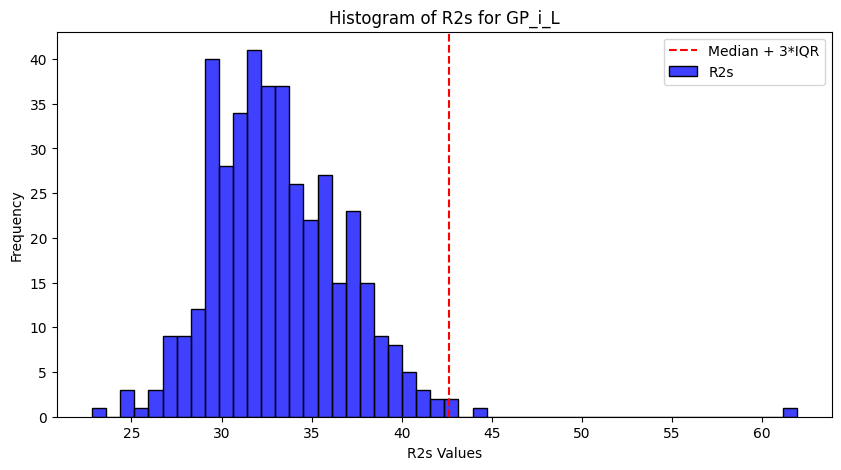

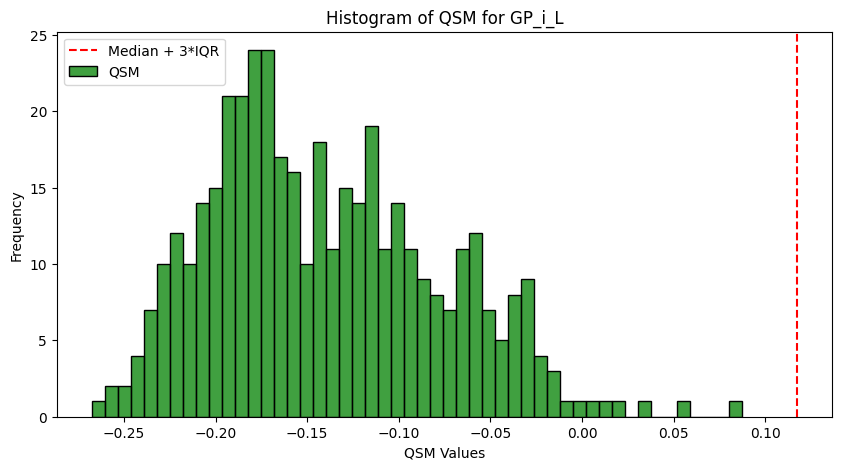

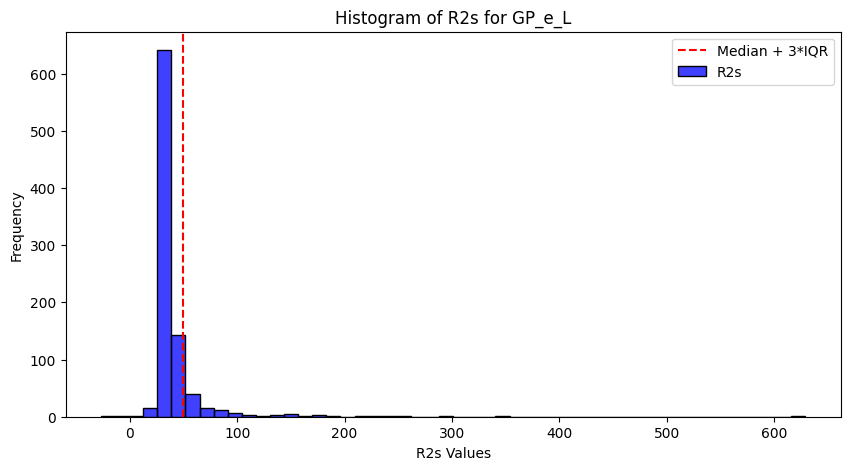

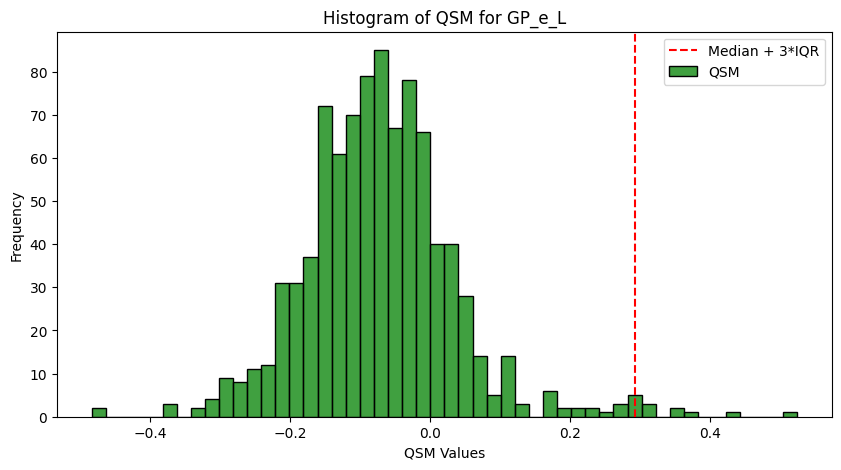

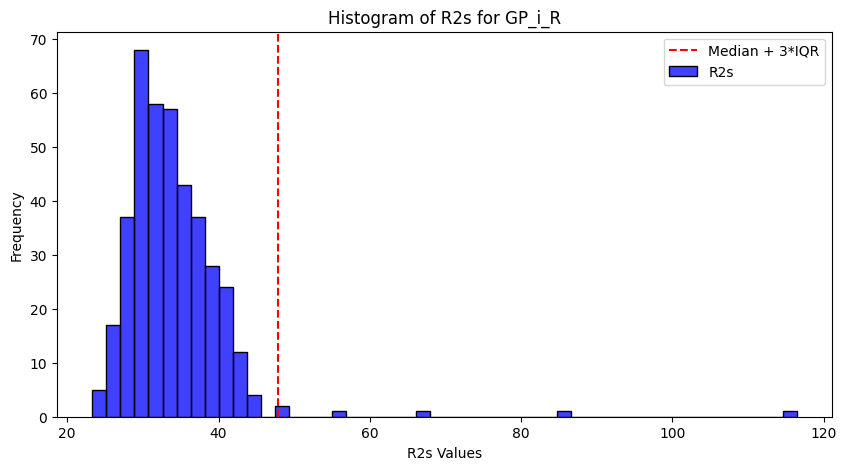

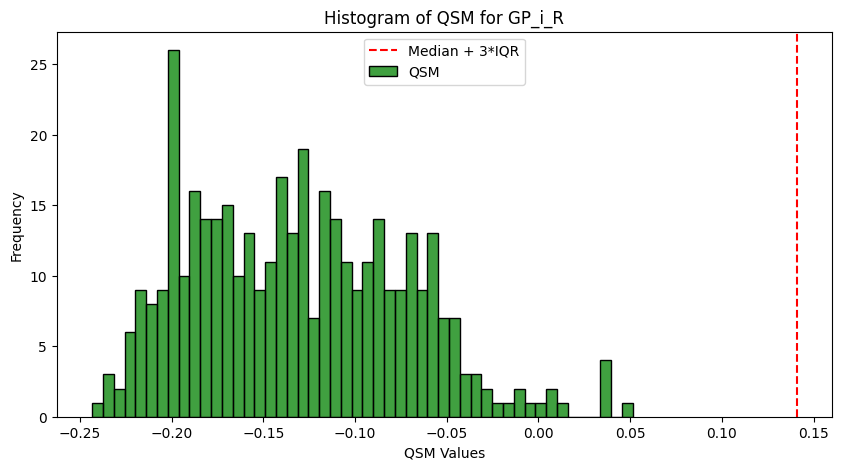

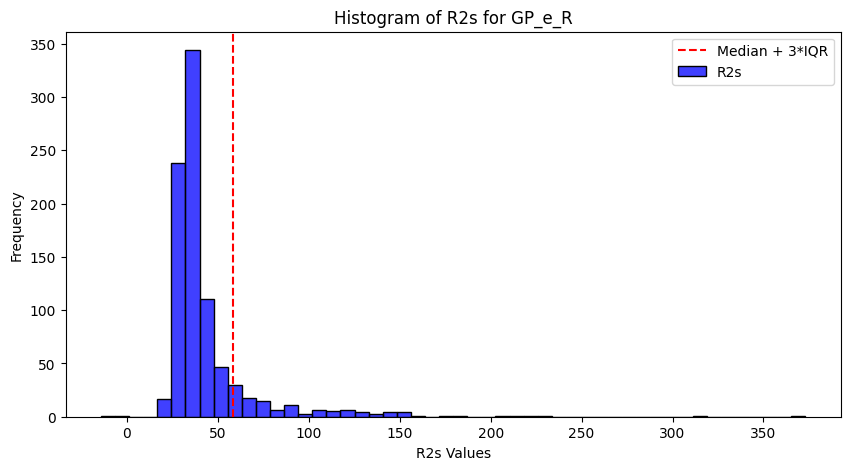

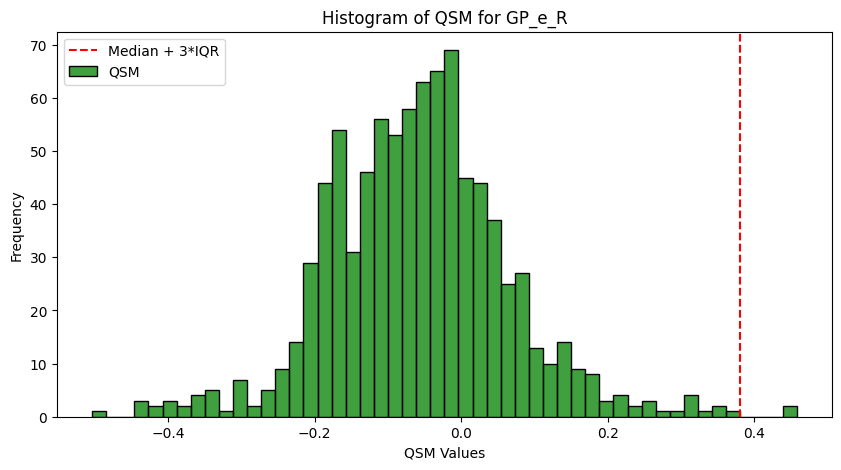

In [10]:
for region, value in region_mapping.items():
    region_mask = (image_struct == value)
    
    # Calcul de la médiane et de l'IQR pour image_R2s
    region_values_R2s = image_R2s[region_mask]
    median_R2s = np.median(region_values_R2s)
    iqr_R2s = np.percentile(region_values_R2s, 75) - np.percentile(region_values_R2s, 25)
    threshold_R2s = median_R2s + 2 * iqr_R2s
    
    # Histogramme pour image_R2s
    plt.figure(figsize=(10, 5))
    sns.histplot(region_values_R2s, bins=50, kde=False, color='blue', label='R2s')
    plt.axvline(threshold_R2s, color='red', linestyle='--', label='Median + 3*IQR')
    plt.title(f"Histogram of R2s for {region}")
    plt.xlabel("R2s Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
    # Calcul de la médiane et de l'IQR pour image_QSM
    region_values_QSM = image_QSM[region_mask]
    median_QSM = np.median(region_values_QSM)
    iqr_QSM = np.percentile(region_values_QSM, 75) - np.percentile(region_values_QSM, 25)
    threshold_QSM = median_QSM + 3 * iqr_QSM
    
    # Histogramme pour image_QSM
    plt.figure(figsize=(10, 5))
    sns.histplot(region_values_QSM, bins=50, kde=False, color='green', label='QSM')
    plt.axvline(threshold_QSM, color='red', linestyle='--', label='Median + 3*IQR')
    plt.title(f"Histogram of QSM for {region}")
    plt.xlabel("QSM Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

{'GP_i_L': -0.09410283654081286, 'GP_e_L': -0.0129899538582527, 'GP_i_R': -0.11094539421752364, 'GP_e_R': -0.05836786462393247}
